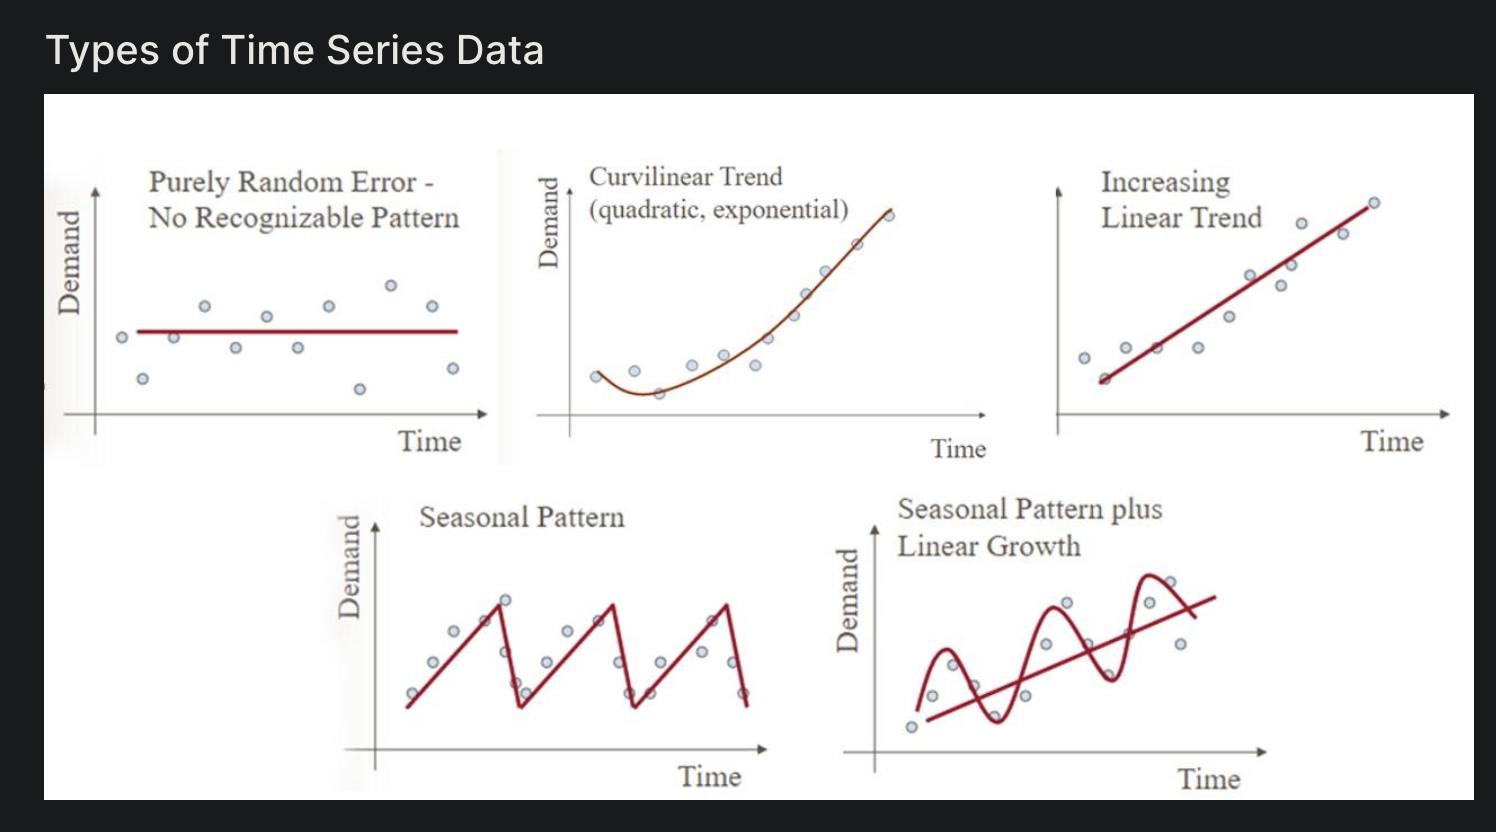

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [11]:
df = pd.read_csv('./data/AEP_hourly.csv')
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [12]:
df.tail()

,Datetime,AEP_MW
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0
121272,2018-01-02 00:00:00,19993.0


In [16]:
df = df.set_index('Datetime')
df.index

Index(['2004-12-31 01:00:00', '2004-12-31 02:00:00', '2004-12-31 03:00:00',
       '2004-12-31 04:00:00', '2004-12-31 05:00:00', '2004-12-31 06:00:00',
       '2004-12-31 07:00:00', '2004-12-31 08:00:00', '2004-12-31 09:00:00',
       '2004-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=121273)

In [17]:
df.index = pd.to_datetime(df.index)

In [19]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


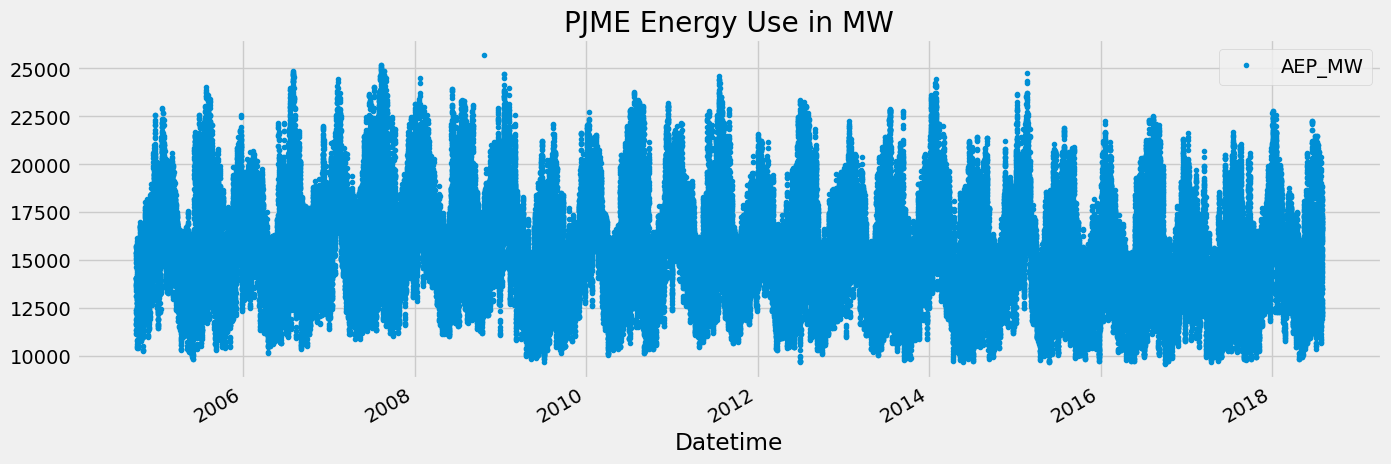

In [18]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

## Train / Test Split

In [20]:
train = df.loc[df.index<'2017-01-01']
test = df.loc[df.index>='2017-01-01']

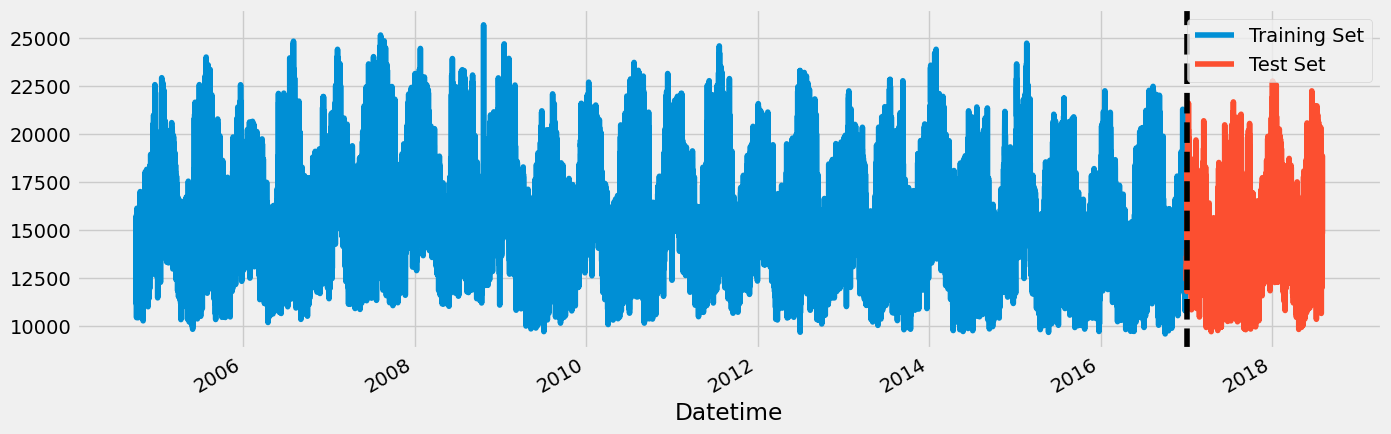

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training set')
test.plot(ax=ax, label='Test set')
ax.axvline('2017-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

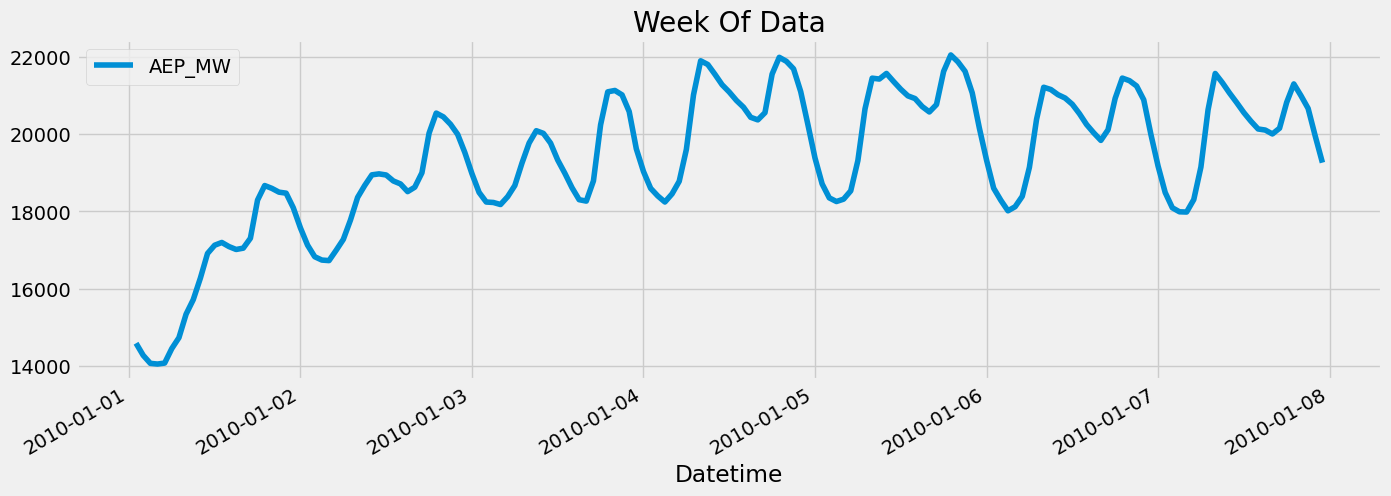

In [28]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [29]:
df.index

DatetimeIndex(['2004-12-31 01:00:00', '2004-12-31 02:00:00',
               '2004-12-31 03:00:00', '2004-12-31 04:00:00',
               '2004-12-31 05:00:00', '2004-12-31 06:00:00',
               '2004-12-31 07:00:00', '2004-12-31 08:00:00',
               '2004-12-31 09:00:00', '2004-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=121273, freq=None)

In [30]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [31]:
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366,31,53
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366,31,53
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366,31,53
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366,31,53
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366,31,53


## Feature / Target Relationship

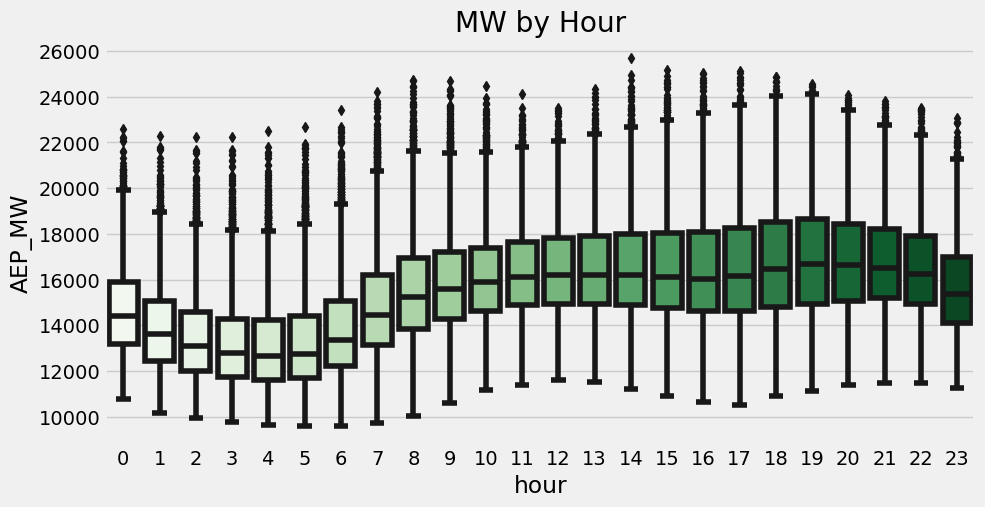

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x='hour', y='AEP_MW', palette='Greens')
ax.set_title('MW by Hour')
plt.show()

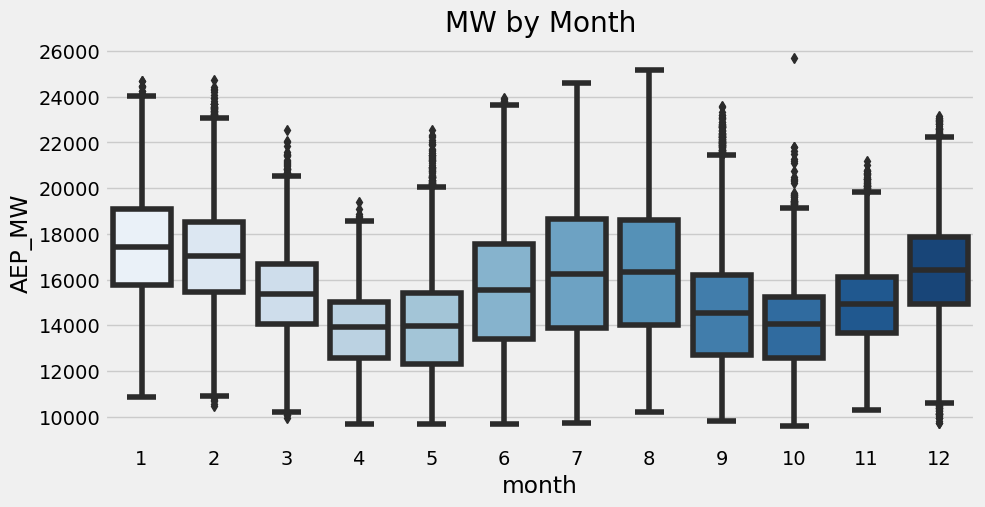

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

## Model Creation

In [41]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [44]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[21:30:56] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15651.59284	validation_1-rmse:14819.29752
[100]	validation_0-rmse:5991.69452	validation_1-rmse:5212.20030
[200]	validation_0-rmse:2711.26530	validation_1-rmse:2285.23007
[300]	validation_0-rmse:1777.35029	validation_1-rmse:1714.35253
[400]	validation_0-rmse:1536.61525	validation_1-rmse:1654.62151
[500]	validation_0-rmse:1458.17048	validation_1-rmse:1644.42253
[554]	validation_0-rmse:1433.07443	validation_1-rmse:1644.58972


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

## Feature Importance

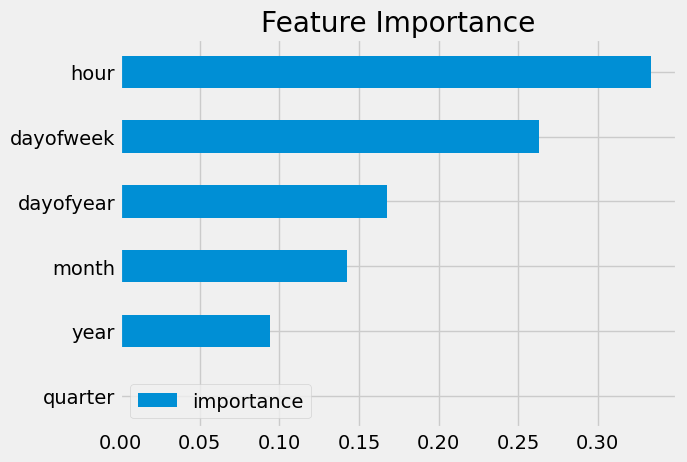

In [49]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast 

In [50]:
test['prediction'] = reg.predict(X_test)

In [51]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

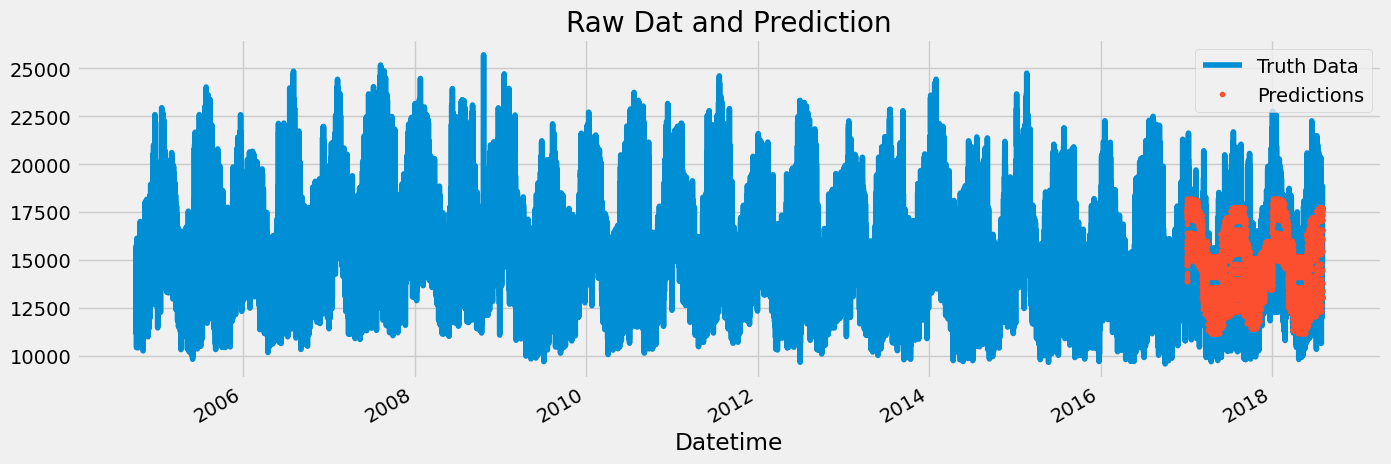

In [52]:
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

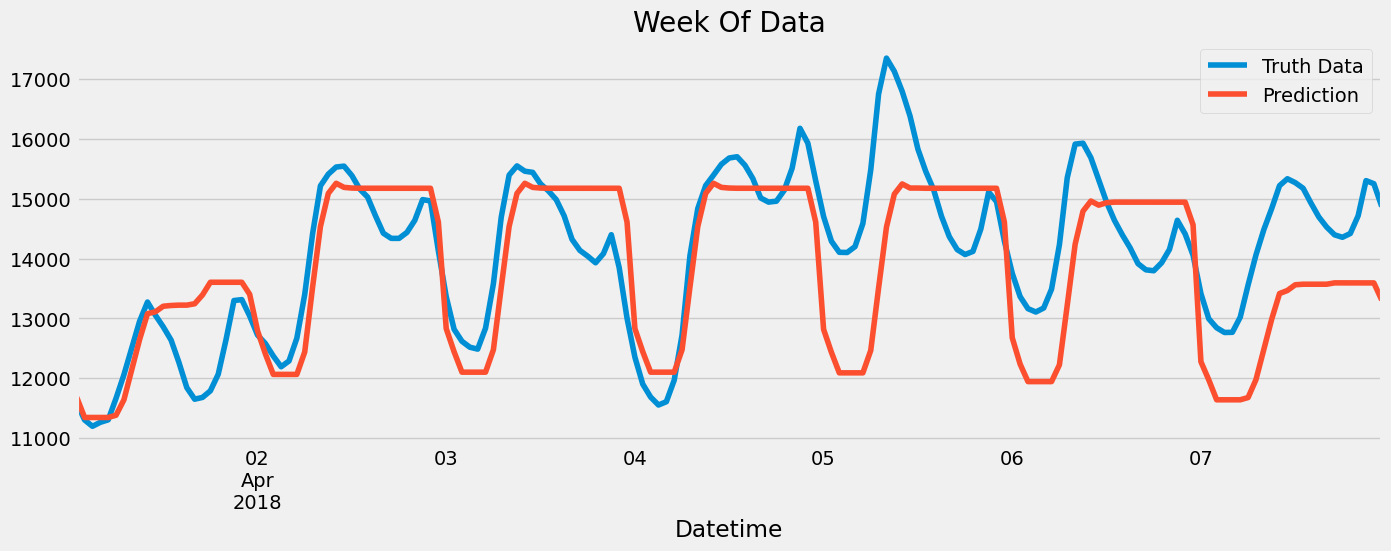

In [54]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot()
plt.legend(['Truth Data','Prediction'])
plt.show()

## SCORE (RMSE)

In [55]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1643.97


In [56]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2018-01-06    4890.941895
2017-12-31    4191.686849
2018-01-07    4161.490641
2018-01-05    4153.803223
2018-01-02    4148.825033
2017-12-28    4103.663127
2018-01-03    3611.143433
2017-03-15    3576.464762
2018-01-01    3544.187337
2018-01-04    3389.101766
Name: error, dtype: float64

In [57]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2017-10-29    263.436279
2017-10-05    273.071818
2017-10-28    313.642782
2018-04-15    343.145182
2017-11-18    353.138265
2017-10-06    359.314982
2017-02-03    360.552165
2018-03-27    364.747192
2017-11-07    379.773926
2018-05-18    383.858236
Name: error, dtype: float64